In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine # database connectio
import os
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

## Cleaning and preprocessing of Questions

## Preprocessing
##### Sample 1M data points
##### Separate Code from Body
##### Remove Spcial characters from Question title and description (not in code)
##### Remove stop words (Except 'C')
##### Remove HTML Tags
##### Convert all the characters into small letters
##### Use SnowballStemmer to stem the word

In [2]:
def striphtml(data):
    # this function will help to remove html tags from the questions in the data
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext

#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:

# below function will help to create table from the database to import data as dataframe
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [4]:
# creating connection with db file
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [5]:
def checktableExist(dbcon):
    cursor = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursor.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall()
    print(tables[0][0])
    return(len(tables))

In [6]:
def create_database_table(db_file, query):
    con = create_connection(db_file)
    if con is not None:
            create_table(con,query)
            checktableExist(con)
    else:
        print('connot create the database connection')
    con.close()

In [27]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [28]:
# selecting random rows from a database
# here we experimenting with 1 million rows

start = dt.datetime.now()
read_db = "train_with_no_duplicate.db"
write_db = 'Processed.db'

if os.path.isfile(read_db):
    db_con = create_connection(read_db)
    if db_con is not None:
        data_reader = db_con.cursor()
        data_reader.execute('select Title, Body,Tags from no_duplicate_data order by RANDOM() limit 100000')
else:
    print('connection not establied')
    
if os.path.isfile(write_db):
    con_w = sqlite3.connect(write_db)
    if con_w is not None:
        # check if table exists
        tables = checktableExist(con_w)
        writer = con_w.cursor()
        if tables != 0:
            writer.execute('delete from QuestionsProcessed where 1')
            print('delete all the rows')
print('time taken',dt.datetime.now()- start)

Tables in the databse:
QuestionsProcessed
delete all the rows
time taken 0:03:24.200953


## __ we have created new database with sampled data

In [29]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = dt.datetime.now()
preprocessed_data_list = []
data_reader.fetchone() # reader for above db
questions_with_code = 0
len_pre = 0
len_post = 0
questions_processed = 0

for row in data_reader:
    is_code = 0
    title,question,tags = row[0],row[1],row[2]
    
    if '<code>' in question:
        questions_with_code += 1
        is_code = 1
        
    x = len(question) + len(title)
    len_pre += x
    
    
    code = str(re.findall(r'<code>(.*?)</code>', question,flags=re.DOTALL))
    
    question = re.sub(r'<code>(.*?)</code>','', question,flags=re.MULTILINE |re.DOTALL)
    question = striphtml(question.encode('utf-8'))
    
    title = title.encode('utf-8')
    question = str(title) + " " + str(question)
    question = re.sub('[^A-Za-z]+'," ",question)
    words = word_tokenize(str(question.lower()))
# now we would be removing all the stopwords and single letters except c
    '''question = []
    for i in words:
        x = " "
        if i not in stop_words and (len(i)!= 0 or j =='c'):
            y = str(stemmer.stem(i))
            x.join(y)'''
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    len_post += len(question)
    tup = (question,code,tags,x,len(question), is_code)
    questions_processed +=1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values(?,?,?,?,?,?)",tup)
    if (questions_processed%100000==0):
        print('number of question processed',questions_processed)
no_dup_avg_len_pre=(len_pre*1.0)/questions_processed
no_dup_avg_len_post=(len_post*1.0)/questions_processed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))

print("Time taken to run this cell :", dt.datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1171
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:04:38.683416


In [30]:
con_w.commit()
db_con.commit()
con_w.close()
db_con.close()

In [33]:
if os.path.isfile('Processed.db'):
    con_r = sqlite3.connect('Processed.db')
    if con_r is not None:
        reader = con_r.cursor()
        reader.execute('Select question from QuestionsProcessed LIMIT 10')
        # outputs of the above query is being saved in reader
        print('Questions after preprocessing are displayed below')
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
            
con_r.commit()
con_r.close()

Questions after preprocessing are displayed below
('detect touch uiimageview uitableviewcel object uitableviewcellstylesubtitl style use object uitableviewcellstylesubtitl style imageview left textlabel bold detailtextlabel creat tabl need detect touch uiimageview also know indexpath cell imageview click tri use work whenev imag click didselectrowatindexpath call want creat separ add custom button way detect touch',)
----------------------------------------------------------------------------------------------------
('php pseudocod tool convert php sourc pseudocod automat implement algorithm want standard independ languag pseudocod pleas help find tool edit exampl php sourc pseudocod',)
----------------------------------------------------------------------------------------------------
('grep window xp vs window use grep gnuwin window window xp follow grep foo nul result follow output grep nul invalid argument window argument result output grep exit without error messag output differ w

In [34]:
# fetching the sampled data from the processed db
if os.path.isfile("Processed.db"):
    con = sqlite3.connect('Processed.db')
    if con is not None:
        preprocessed_data  =  pd.read_sql_query('select question, Tags from QuestionsProcessed', con)
con.commit()
con.close()

In [35]:
preprocessed_data

,question,tags
0,javascript get dom except creat custom event u...,javascript android phonegap
1,detect touch uiimageview uitableviewcel object...,iphone objective-c uitableview uitableviewcell...
2,php pseudocod tool convert php sourc pseudocod...,php
3,grep window xp vs window use grep gnuwin windo...,windows-7 grep gnuwin32
4,java format word string exampl text file conta...,java arraylist
...,...,...
99994,swap view tab bar app call view control direct...,iphone objective-c
99995,creat swf file video control code creat file v...,flash
99996,cakephp undefin class constant attachmentbehav...,cakephp
99997,group modulo prime general follow statement pr...,elementary-number-theory


In [37]:
print('number of data points in processed data', preprocessed_data.shape[0])
print('number of dimentions in the data', preprocessed_data.shape[1])

number of data points in processed data 99999
number of dimentions in the data 2


This case is mostly related to multi-label classification we need to convert tags in single column to different labels

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer(tokenizer= lambda x: x.split(), binary='true')
multilabel_y = vectoriser.fit_transform(preprocessed_data['tags'])

<99999x18578 sparse matrix of type '<class 'numpy.int64'>'
	with 290041 stored elements in Compressed Sparse Row format>

We have already seen in the EDA that we have more than 42 tags and if we are considering all the tags in then we require a lot of computing resources

In [45]:
def tagsToChose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags = sorted(range(len(t)),key=lambda i: t[i],reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags[:n]]
    return multilabel_yn

In [47]:
def question_explained_fn(n):
    multilabel_yn = tagsToChose(n)
    x = multilabel_yn.sum(axis=1)
    return np.count_nonzero(x==0)

In [53]:
question_explained = []
totat_tags = multilabel_y.shape[1]
total_qs = multilabel_y.shape[0]
for i in range(500,totat_tags,100):
    question_explained.append(np.round((total_qs-question_explained_fn(i)/total_qs)*100,3))
    

In [49]:
totat_tags

18578

In [50]:
total_qs

99999

C:\Users\saksh\AppData\Local\Temp\ipykernel_14816\983187884.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel)


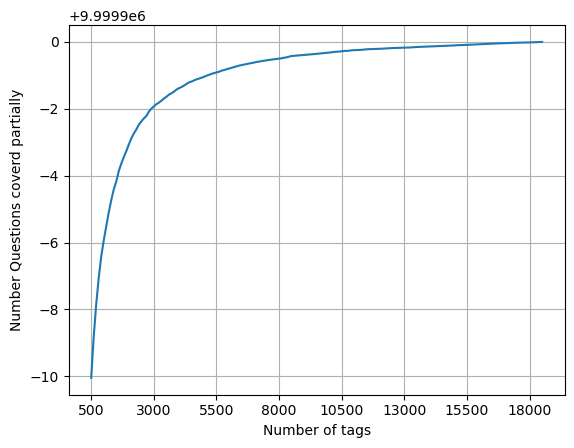

with  5500 tags we are covering  9999899.086 % of questions


In [56]:
ig, ax = plt.subplots()
ax.plot(question_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",question_explained[50],"% of questions")

In [57]:
multilabel_yx = tagsToChose(5500)
print('number of questions that are not covered in the select tags are', question_explained_fn(5500),'out of', total_qs)

number of questions that are not covered in the select tags are 914 out of 99999


In [59]:
print('number of tags in sampple are',multilabel_y.shape[1])

number of tags in sampple are 18578


#### we covering 99.4 percent of question using top 15% of the tags

In [60]:
# spliting the data
total_size = preprocessed_data.shape[0]
train_size = int(0.80* total_size)

xtrain = preprocessed_data.head(train_size)
xtest = preprocessed_data.head(total_size-train_size)

ytrain = multilabel_yx[0:train_size,:]
ytest = multilabel_yx[train_size:total_size,:]

In [64]:
ytest.shape[0]

20000

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
start = dt.datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(xtrain['question'])
x_test_multilabel = vectorizer.transform(xtest['question'])
print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:00:38.673219


In [109]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",ytrain.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",ytest.shape)

Dimensions of train data X: (79999, 89328) Y : (79999, 5500)
Dimensions of test data X: (20000, 89328) Y: (20000, 5500)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [ ]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl')

In [110]:
# Creating the model with 0.5 million data point and 500 tags

In [111]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [113]:
read_db = 'train_with_no_duplicate.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_duplicate_data LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checktableExist(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<ol>
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [117]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = dt.datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], str(row[2])

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    # adding title three time to the data to increase its weight
    # add tags string to the training data

    question=str(title)+" "+str(title)+" "+str(title)+" "+question

#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", dt.datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:18:17.803557


In [118]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [119]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advanc ..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

In [120]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [121]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [122]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [124]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-question_explained_fn(i))/total_qs)*100,3))

C:\Users\saksh\AppData\Local\Temp\ipykernel_14816\1194059314.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel)


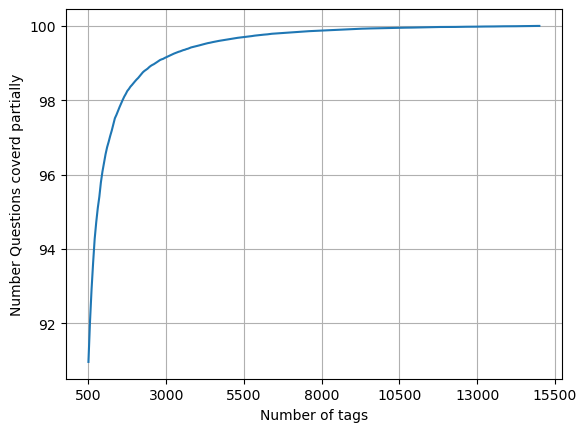

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [125]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [128]:
# we will be taking 500 tags
multilabel_yx = tagsToChose(500)
print("number of questions that are not covered :", question_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [129]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [130]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [132]:
#  Featurizing data with TfIdf vectorizer
start = dt.datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:09:48.938441


In [133]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95054) Y : (400000, 500)
Dimensions of test data X: (100000, 95054) Y: (100000, 500)


In [135]:
start = dt.datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",accuracy_score(y_test, predictions))
print("Hamming loss ",hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", dt.datetime.now() - start)

Accuracy : 0.23658
Hamming loss  0.00278154
Micro-average quality numbers
Precision: 0.7206, Recall: 0.3264, F1-measure: 0.4493


C:\Users\saksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro-average quality numbers
Precision: 0.5507, Recall: 0.2584, F1-measure: 0.3354


NameError: name 'metrics' is not defined